In [1]:
# !pip install -U openmim
# !mim install mmengine
# # !mim install 'mmcv>=2.0.0rc1'
# !mim install 'mmcv==2.0.0rc3'

# !pip install opencv-python pillow matplotlib seaborn tqdm 'mmdet>=3.0.0rc1' -i https://pypi.tuna.tsinghua.edu.cn/simple

##　下载数据集并解压

In [2]:
# # 下载数据集并解压
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/Glomeruli-dataset.zip
# # 解压
# !unzip Glomeruli-dataset.zip >> /data/Glomeruli-dataset

In [3]:
%matplotlib inline

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
# from sklearn.metrics import jaccard_similarity_score

In [4]:
PATH_IMAGE = 'data/Glomeruli-dataset/images'
PATH_MASKS = 'data/Glomeruli-dataset/masks'

print('图像个数', len(os.listdir(PATH_IMAGE)))
print('标注个数', len(os.listdir(PATH_MASKS)))

图像个数 2575
标注个数 2575


In [5]:
# 指定图像文件名
file_name = 'SAS_21883_001_10.png'

img_path = os.path.join(PATH_IMAGE, file_name)
mask_path = os.path.join(PATH_MASKS, file_name)

print('图像路径', img_path)
print('标注路径', mask_path)


图像路径 data/Glomeruli-dataset/images/SAS_21883_001_10.png
标注路径 data/Glomeruli-dataset/masks/SAS_21883_001_10.png


In [6]:
import cv2
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)
img.shape,mask.shape

((1024, 1024, 3), (1024, 1024, 3))

In [7]:
# mask 语义分割标注，与原图大小相同，0 为 背景， 1 为 肾小球
np.unique(mask)

array([0, 1], dtype=uint8)

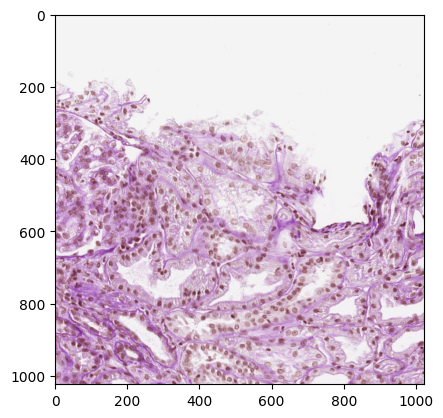

In [8]:
# 可视化图像
plt.imshow(img)
plt.show()

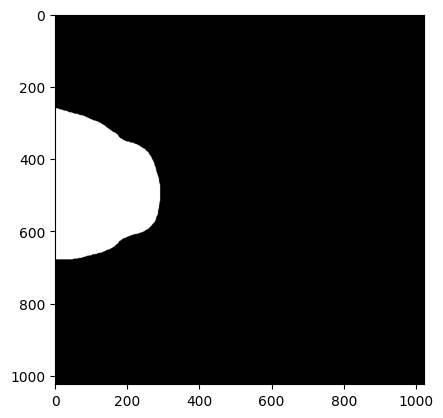

In [9]:
# 可视化语义分割标注
plt.imshow(mask*255)
plt.show()

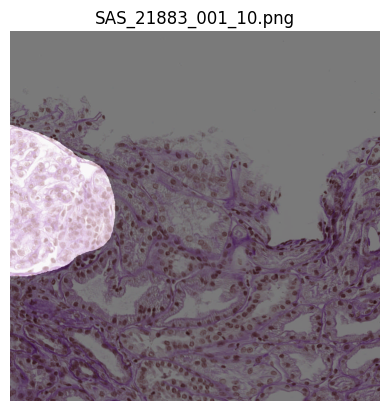

In [10]:
plt.imshow(img)
plt.imshow(mask * 255, alpha=0.5)  # alpha 高亮区域透明度，越小越接近原图
plt.title(file_name)
plt.axis('off')
plt.show()

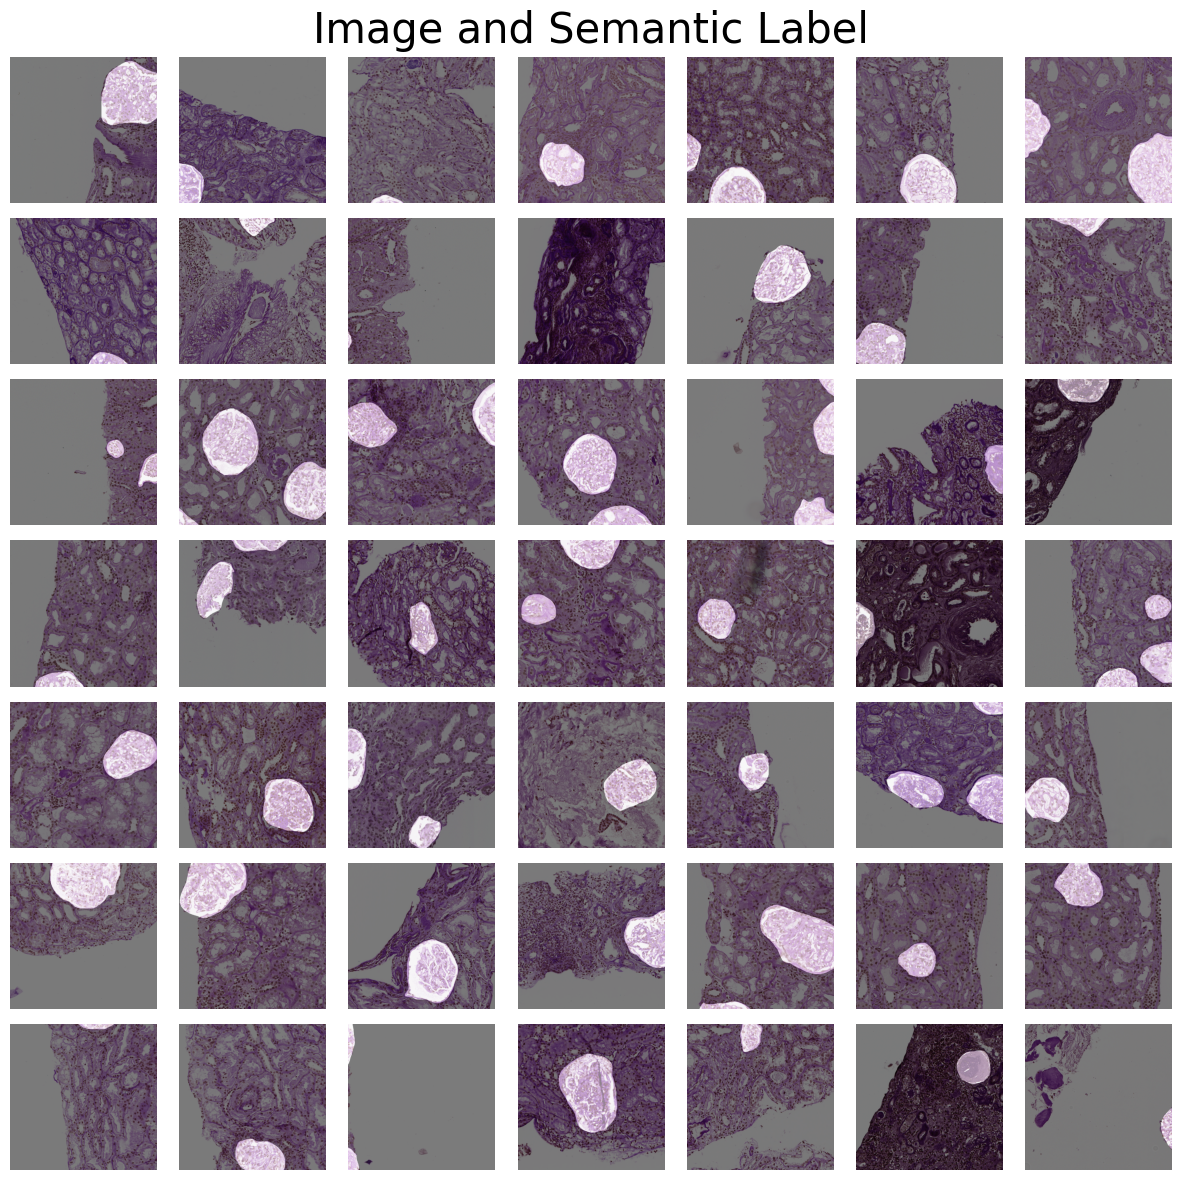

In [11]:
# n行n列可视化
n = 7

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

i = 0

for file_name in os.listdir(PATH_IMAGE):

    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    if 1 in mask:
        axes[i//n, i%n].imshow(img)
        axes[i//n, i%n].imshow(mask*255, alpha=opacity)
        axes[i//n, i%n].axis('off') # 关闭坐标轴显示
        i += 1
    if i > n**2-1:
        break
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()

In [12]:
import random
PATH_IMAGE = 'data/Glomeruli-dataset/images'
all_file_list = os.listdir(PATH_IMAGE)
all_file_num = len(all_file_list)
random.shuffle(all_file_list) # 随机打乱全部数据文件名列表

In [13]:
train_ratio = 0.8
test_ratio = 1 - train_ratio
train_file_list = all_file_list[:int(all_file_num*train_ratio)]
test_file_list = all_file_list[int(all_file_num*train_ratio):]

print('数据集图像总数', all_file_num)
print('训练集划分比例', train_ratio)
print('训练集图像个数', len(train_file_list))
print('测试集图像个数', len(test_file_list))

数据集图像总数 2575
训练集划分比例 0.8
训练集图像个数 2060
测试集图像个数 515


In [14]:
train_file_list[:5],test_file_list[:5]

(['SAS_21942_001_70.png',
  'SAS_21937_001_133.png',
  'SAS_21891_001_38.png',
  'SAS_21904_001_45.png',
  'VUHSK_1762_49.png'],
 ['SESCAM_102_75.png',
  'SESCAM_1_0_11.png',
  'VUHSK_1272_129.png',
  'VUHSK_1352_17.png',
  'VUHSK_1622_226.png'])

In [15]:
txt_path = 'data/Glomeruli-dataset/splits'

# os.mkdir(txt_path)
with open(f'{txt_path}/train.txt', 'w') as f:
    f.writelines(line.split('.')[0] + '\n' for line in train_file_list)
with open(f'{txt_path}/val.txt', 'w') as f:
    f.writelines(line.split('.')[0] + '\n' for line in test_file_list)

## 模型训练

In [1]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 数据集图片和标注路径
data_root = 'data/Glomeruli-dataset'
img_dir = 'images'
ann_dir = 'masks'

# 类别和对应的颜色
classes = ('background', 'glomeruili')
palette = [[128, 128, 128], [151, 189, 8]]

In [3]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

#
#
## KeyError: 'StanfordBackgroundDataset is already registered in dataset at mmseg.datasets.StanfordBackgroundDataset'
#
# @DATASETS.register_module()
# class StanfordBackgroundDataset(BaseSegDataset):
#   METAINFO = dict(classes = classes, palette = palette)
#   def __init__(self, **kwargs):
#     super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [4]:
# # 下载 config 文件 和 预训练模型checkpoint权重文件
# !mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

In [5]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [6]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (512, 512)  # 256 ->128  表现下降，512
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 4 # 8 训练太卡

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = './work_dirs/glomeruili3'

# 训练迭代次数
cfg.train_cfg.max_iters = 1200
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 400

# 随机数种子
cfg['randomness'] = dict(seed=10)  # 0 -->10
# 修改lr
cfg['optimzer'] = dict(type='Adam', lr=0.005, momentum=0.9, weight_decay=0.0005)  ## 0.0001太小   0.001 --> 0.005

In [7]:
print(cfg.pretty_text)

norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels

In [8]:
cfg.dump('new_cfg_Glomeruli3.py')

In [9]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/15 05:04:36 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jan 17 2023, 23:13:24) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 10
    GPU 0: NVIDIA GeForce GTX 1080 Ti
    CUDA_HOME: /home/cine/miniconda3/envs/mmlab2
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode

/home/cine/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/cine/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/cine/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/cine/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the s

02/15 05:04:39 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/15 05:04:39 - mmengine - WARNING - The "hook" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:39 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook  

/home/cine/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [10]:
runner.train()

02/15 05:04:40 - mmengine - WARNING - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:40 - mmengine - WARNING - The "dataset" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:40 - mmengine - WARNING - The "transform" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:40 - mmengine - WARNING - The "data sampler" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:40 - mmengine - WARNING - The "optimizer wrapper constructor" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:40 - mmengine - WARNING - The "optimizer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:

/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/evaluator/metric.py:47: UserWarning: The prefix is not set in metric class IoUMetric.
  warnings.warn('The prefix is not set in metric class '


02/15 05:04:40 - mmengine - WARNING - The "weight initializer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 05:04:40 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
02/15 05:04:40 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
02/15 05:04:40 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [11]:
# 载入 config 配置文件
from mmengine import Config
from mmengine.runner import Runner
from mmseg.utils import register_all_modules
from mmseg.apis import init_model, inference_model, show_result_pyplot
cfg = Config.fromfile('new_cfg_Glomeruli.py')
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/15 05:19:56 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jan 17 2023, 23:13:24) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce GTX 1080 Ti
    CUDA_HOME: /home/cine/miniconda3/envs/mmlab2
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;

AssertionError: class `SegLocalVisualizer` in mmseg/visualization/local_visualizer.py: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not access any other arguments

In [ ]:
# 初始化模型
checkpoint_path = './work_dirs/glomeruili2/iter_800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

In [35]:
# 单张图像
img = mmcv.imread('data/Glomeruli-dataset/images/SAS_21908_001_42.png')

In [36]:
result = inference_model(model, img)
result.keys()

['pred_sem_seg', 'seg_logits']

In [37]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
pred_mask.shape

(1024, 1024)

In [38]:
np.unique(pred_mask)

array([0, 1])

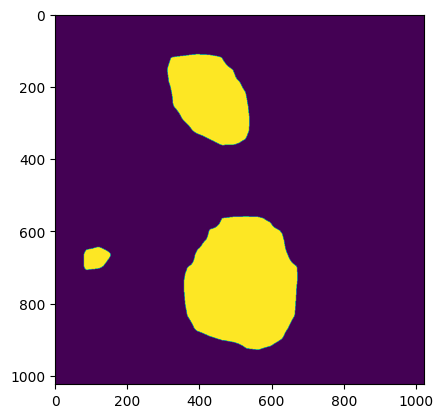

In [39]:
# mask
plt.imshow(pred_mask)
plt.show()

/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:163: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


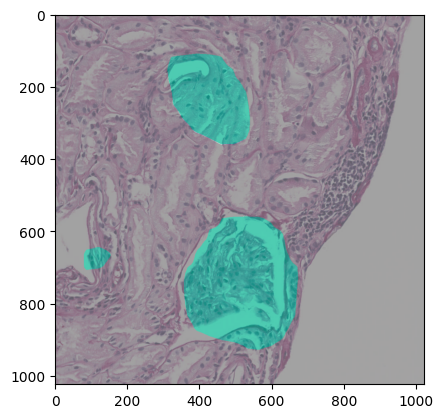

In [40]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

In [41]:
# 联通域分析
connected = cv2.connectedComponentsWithStats(np.uint8(pred_mask), connectivity=4)

# 连通域个数（第一个有可能是全图，可以忽略）
connected[0]

4

In [42]:
# 用整数表示每个连通域区域
connected[1].shape

(1024, 1024)

In [43]:
np.unique(connected[1])

array([0, 1, 2, 3], dtype=int32)

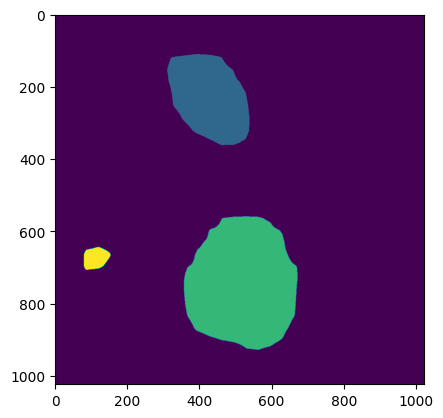

In [44]:
plt.imshow(connected[1])
plt.show()

In [45]:
# 每个连通域外接矩形的左上角X、左上角Y、宽度、高度、面积
connected[2]

array([[     0,      0,   1024,   1024, 912018],
       [   311,    111,    227,    252,  42615],
       [   357,    560,    314,    369,  90390],
       [    80,    645,     74,     63,   3553]], dtype=int32)

In [46]:
# 每个连通域的质心坐标
connected[3]

array([[516.35930102, 500.62015662],
       [427.35726857, 231.72152998],
       [517.8348158 , 746.73357672],
       [112.22291022, 675.47678019]])

In [60]:
# 获取测试集标注
label = mmcv.imread('data/Glomeruli-dataset/masks/SAS_21908_001_42.png')
label_mask = label[:,:,0]
label_mask.shape

(1024, 1024)

In [61]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

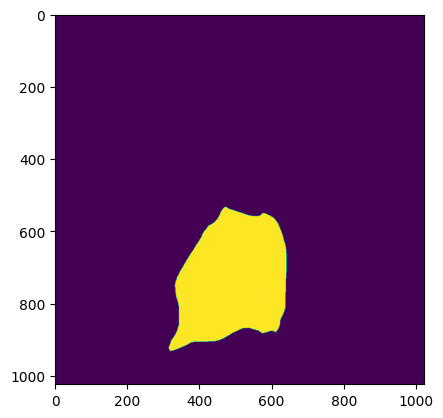

In [62]:
plt.imshow(label_mask)
plt.show()

In [63]:
# 测试集标注
label_mask.shape

(1024, 1024)

In [64]:
# 语义分割预测结果
pred_mask.shape

(1024, 1024)

In [65]:
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)

In [66]:
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)

In [67]:
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)

In [68]:
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)

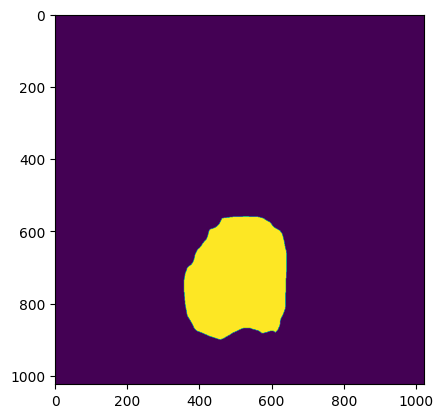

In [69]:
plt.imshow(TP)
plt.show()

In [70]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 10


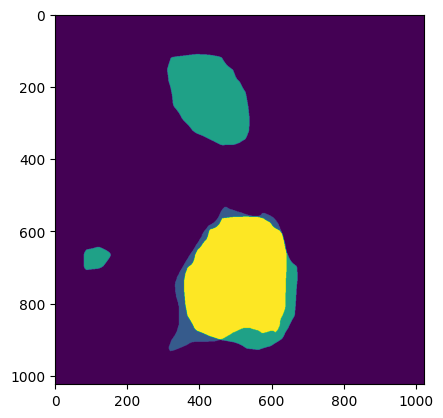

In [71]:
plt.imshow(confusion_map)
plt.show()

In [73]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

In [74]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))

    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)

    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

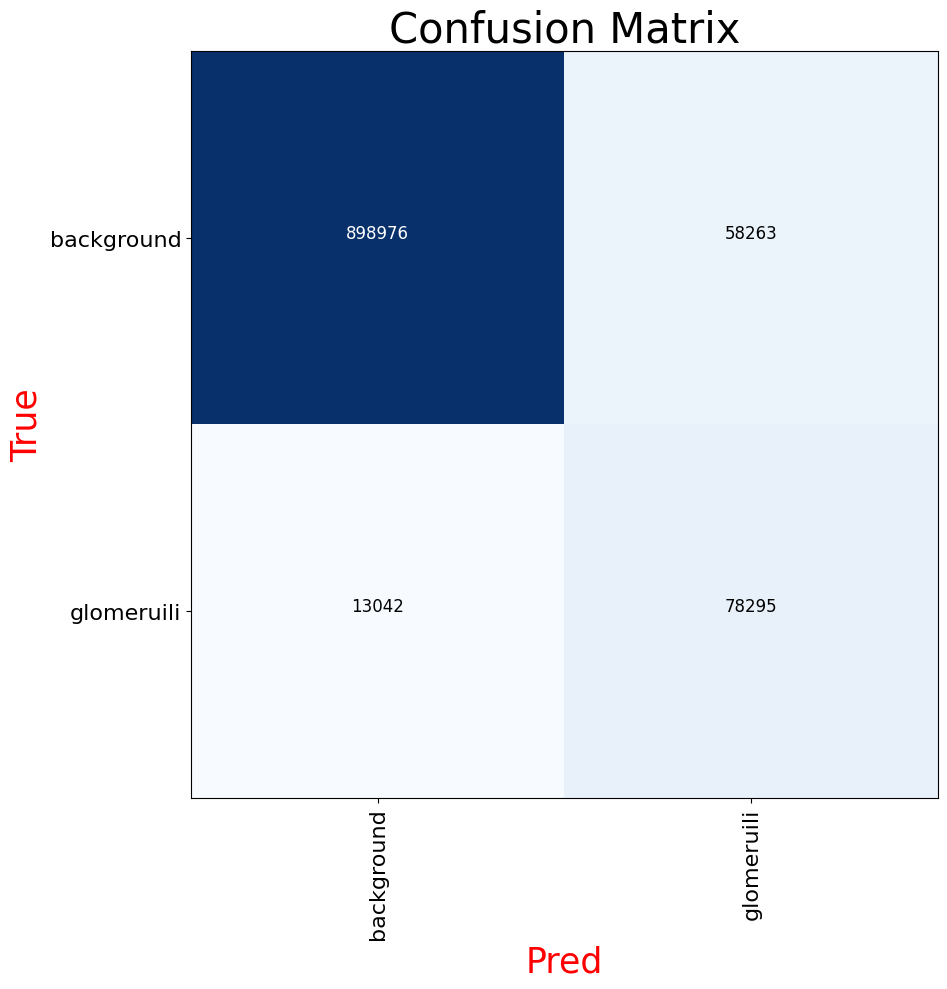

In [75]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

In [76]:
## 添加数据集类
# 数据集配置文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/StanfordBackgroundDataset.py -O ../mmsegmentation/mmseg/datasets/StanfordBackgroundDataset.py

# 修改 ../mmsegmentation/mmseg/datasets/__init__.py，添加数据集
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/__init__.py -O ../mmsegmentation/mmseg/datasets/__init__.py


--2023-02-15 04:38:37--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/StanfordBackgroundDataset.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455 [binary/octet-stream]
Saving to: ‘../mmsegmentation/mmseg/datasets/StanfordBackgroundDataset.py’

../mmsegmentation/m 100%[===================>]     455  --.-KB/s    in 0.001s  

2023-02-15 04:38:38 (718 KB/s) - ‘../mmsegmentation/mmseg/datasets/StanfordBackgroundDataset.py’ saved [455/455]

--2023-02-15 04:38:38--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/__init__.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
C

In [12]:
# 测试集精度指标
!python ../mmsegmentation/tools/test.py new_cfg_Glomeruli3.py ./work_dirs/glomeruili3/iter_800.pth

02/15 06:01:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jan 17 2023, 23:13:24) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 10
    GPU 0: NVIDIA GeForce GTX 1080 Ti
    CUDA_HOME: /home/cine/miniconda3/envs/mmlab2
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode

In [13]:
# 速度指标-FPS
!python ../mmsegmentation/tools/analysis_tools/benchmark.py new_cfg_Glomeruli3.py ./work_dirs/glomeruili3/iter_800.pth

Run 1:
02/15 06:02:50 - mmengine - WARNING - The "dataset" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 06:02:50 - mmengine - WARNING - The "transform" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 06:02:50 - mmengine - WARNING - The "data sampler" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 06:02:50 - mmengine - WARNING - The "model" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
/home/cine/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/cine/mmsegmen